# 1. Problem Statement

## 1.1 Project Title

Understanding Customer Sentiment and QnA over Amazon Product Reviews

## 1.2 Project Problem Statement

With the exponential growth of e-commerce platforms like Amazon, users face information overload when trying to evaluate products based on thousands of customer reviews. These reviews are often redundant, lengthy, and inconsistent in tone, making it difficult for prospective buyers to get a clear and quick understanding of a product's strengths and weaknesses.

## 1.3 Proposed Approach

We believe an automated sentiment classification and summarization pipeline that:


1. Classifies customer reviews as positive or negative using a fine-tuned transformer-based sentiment classifier.


2. Aggregates sentiment per product, identifying the distribution of customer experiences.


3. Extracts the most helpful reviews, based on user helpfulness votes, to provide qualitative context.


4. Generates a concise 1–2 sentence summary per product using a Large Language Model, summarizing key strengths, major issues, and an overall recommendation that would help users and business owners understand the sentiment of the product.


5. And dive even deeper by generating sentence summary per product on each topic using a LLM to summarize key points per topic, will help create a chatbot both business owners and users can use to query important questions that can be answered based of the reviews.


Would help solve our problem.


# 2. Data Understanding (EDA)

In [4]:
import pandas as pd
import numpy as np

In [ ]:

# Replace paths with your exact locations if needed
fn1 = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
fn2 = "1429_1.csv"
fn3 = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"

cols = ['asins', 'reviews.rating', 'name', 'brand', 'categories',
       'reviews.text', 'reviews.title', 'reviews.username', 'reviews.numHelpful']

# Load each, ignoring other columns
df1 = pd.read_csv(fn1, usecols=cols)
df2 = pd.read_csv(fn2, usecols=cols)
df3 = pd.read_csv(fn3, usecols=cols)

df = pd.concat([df1, df2, df3], ignore_index=True)
df.to_csv("amazon_reviews.csv", index=False)

/tmp/ipython-input-28-3579109737.py:13: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(fn2, usecols=cols)


In [5]:
###Import Data
### Note:  Data is in the zip. Extract it to the folder data
review_df=pd.read_csv("amazon_reviews.csv")

In [30]:
review_df.columns

Index(['name', 'asins', 'brand', 'categories', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username'],
      dtype='object')

## 2.1 Exploring Missing Values and Duplicates

Code to see missing percentages per column

In [16]:
# Calculate missing values and percentages
missing_summary = review_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_summary / len(review_df)) * 100

# Combine into a summary DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_percentage.round(2)
})

print("Missing Value Summary:")
print(missing_df)


Missing Value Summary:
                    Missing Count  Missing %
reviews.numHelpful          12746      18.75
name                         6760       9.94
reviews.rating                 33       0.05
reviews.title                  19       0.03
reviews.username               13       0.02
asins                           2       0.00
reviews.text                    1       0.00
brand                           0       0.00
categories                      0       0.00


Lets see if there are duplicate reviews, review titles, users name, and product name combinations

In [20]:
# Count duplicate reviews based on review text
duplicate_counts = review_df.duplicated(subset=["reviews.text"], keep=False).sum()

print(f"Total duplicate reviews (by text): {duplicate_counts}")
# Show actual duplicate rows
duplicates = review_df[review_df.duplicated(subset=["reviews.text"], keep=False)]
print(" Example duplicate reviews:")
print(duplicates[["name", "reviews.text"]].head())

# Show duplicate reviews based on title + text
duplicate_combo = review_df.duplicated(subset=["reviews.title", "reviews.text"], keep=False).sum()
print(f" Duplicate reviews based on title + text: {duplicate_combo}")

#Show duplicate reviews based on title + text + username
duplicate_combo_users = review_df.duplicated(subset=["reviews.title", "reviews.text", "reviews.username", "name"], keep=False).sum()   
print(f" Duplicate reviews based on title + text + username + name of product: {duplicate_combo_users}")


Total duplicate reviews (by text): 30851
 Example duplicate reviews:
                                                 name  \
1   AmazonBasics AAA Performance Alkaline Batterie...   
6   AmazonBasics AAA Performance Alkaline Batterie...   
7   AmazonBasics AAA Performance Alkaline Batterie...   
13  AmazonBasics AAA Performance Alkaline Batterie...   
14  AmazonBasics AAA Performance Alkaline Batterie...   

                                         reviews.text  
1   Bulk is always the less expensive way to go fo...  
6   ive not had any problame with these batteries ...  
7   Well if you are looking for cheap non-recharge...  
13  just got em so I can't really comment on how g...  
14  we have many things that need aa battery they ...  
 Duplicate reviews based on title + text: 30485
 Duplicate reviews based on title + text + username + name of product: 5159


We see that there are some missing values mainly in reviews.numhelpful, we could fix this by filling for nan values to be 0 here so basically number of people that found that review helpful can be 0. We also see around 5159 reviews + review titles + user names that are duplicates. These can be removed as they are duplicated reviews by the same users on same products.

## 2.2 Products with most reviews

In [22]:
# Count number of reviews per product
product_review_counts = review_df["name"].value_counts()

# Convert to DataFrame for easier analysis
top_products = product_review_counts.reset_index()
top_products.columns = ["product_name", "review_count"]

print("Top products by number of reviews:")
print(top_products.head(10))


Top products by number of reviews:
                                        product_name  review_count
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...         10966
1  AmazonBasics AAA Performance Alkaline Batterie...          8343
2  AmazonBasics AA Performance Alkaline Batteries...          3728
3                 Echo (White),,,\r\nEcho (White),,,          3309
4  Amazon Kindle Paperwhite - eBook reader - 4 GB...          3176
5  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...          3114
6  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...          2814
7             Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,          2527
8  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...          2443
9  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...          2370


/var/folders/vh/s_41kfjx7cngccx9ch_mcx3w0000gn/T/ipykernel_90735/1342745291.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products.head(10), x="review_count", y="product_name", palette="crest")
) missing from font(s) DejaVu Sans.mcx3w0000gn/T/ipykernel_90735/1342745291.py:9: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.0-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


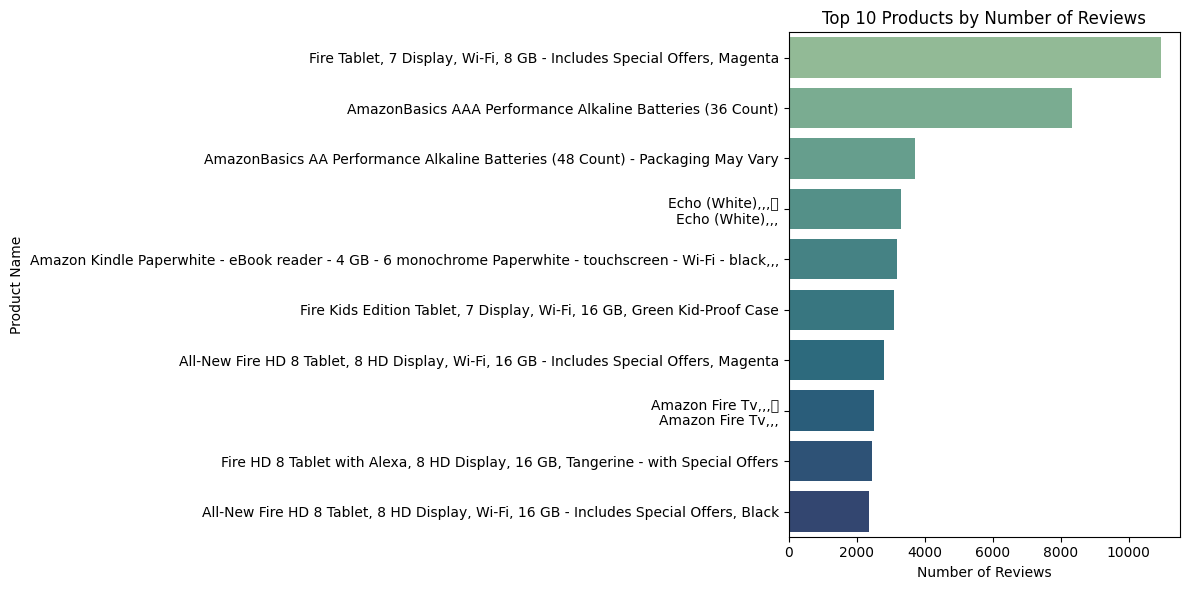

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top_products.head(10), x="review_count", y="product_name", palette="crest")
plt.title("Top 10 Products by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()


## 2.3 Products with most negative and positive reviews

### 2.3.1 Positive

In [26]:
# Filter reviews with rating > 3 (positive sentiment)
positive_reviews = review_df[review_df["reviews.rating"] > 3]
# Count number of positive reviews per product
positive_counts = positive_reviews["name"].value_counts().reset_index()
positive_counts.columns = ["product_name", "positive_review_count"]

print(" Top products with most positive reviews:")
print(positive_counts.head(10))


 Top products with most positive reviews:
                                        product_name  positive_review_count
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...                   9938
1  AmazonBasics AAA Performance Alkaline Batterie...                   7181
2  AmazonBasics AA Performance Alkaline Batteries...                   3210
3                 Echo (White),,,\r\nEcho (White),,,                   3126
4  Amazon Kindle Paperwhite - eBook reader - 4 GB...                   3079
5  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...                   2836
6  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...                   2667
7             Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                   2397
8  Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...                   2325
9  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...                   2243


/var/folders/vh/s_41kfjx7cngccx9ch_mcx3w0000gn/T/ipykernel_90735/3651887129.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=positive_counts.head(10), x="positive_review_count", y="product_name", palette="Greens")
) missing from font(s) DejaVu Sans.mcx3w0000gn/T/ipykernel_90735/3651887129.py:9: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.0-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


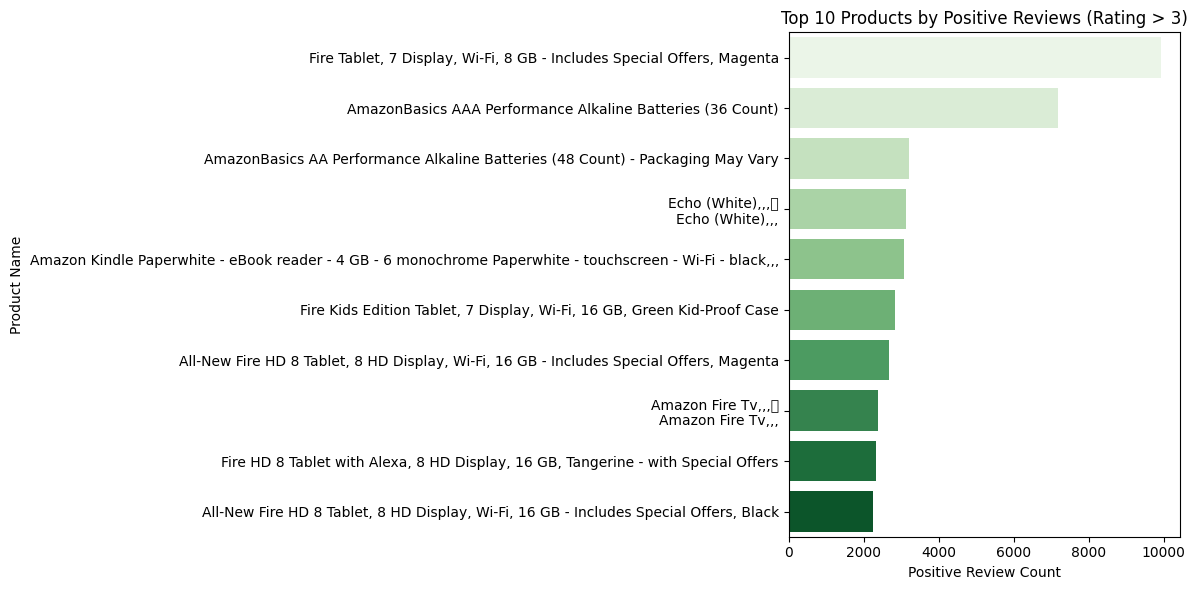

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=positive_counts.head(10), x="positive_review_count", y="product_name", palette="Greens")
plt.title("Top 10 Products by Positive Reviews (Rating > 3)")
plt.xlabel("Positive Review Count")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()


### 2.3.2 Negative Reviews

In [28]:
# Filter reviews with rating <= 2 (negative sentiment)
negative_reviews = review_df[review_df["reviews.rating"] <= 3]
# Count number of negative reviews per product
negative_counts = negative_reviews["name"].value_counts().reset_index()
negative_counts.columns = ["product_name", "negative_review_count"]

print("Top products with most negative reviews (rating ≤ 3):")
print(negative_counts.head(10))


Top products with most negative reviews (rating ≤ 3):
                                        product_name  negative_review_count
0  AmazonBasics AAA Performance Alkaline Batterie...                   1162
1  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...                   1024
2  AmazonBasics AA Performance Alkaline Batteries...                    518
3  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...                    278
4                 Echo (White),,,\r\nEcho (White),,,                    183
5  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...                    160
6  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...                    147
7  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...                    147
8             Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                    130
9  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...                    127


/var/folders/vh/s_41kfjx7cngccx9ch_mcx3w0000gn/T/ipykernel_90735/2135048444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=negative_counts.head(10), x="negative_review_count", y="product_name", palette="Reds")
) missing from font(s) DejaVu Sans.mcx3w0000gn/T/ipykernel_90735/2135048444.py:9: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.0-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


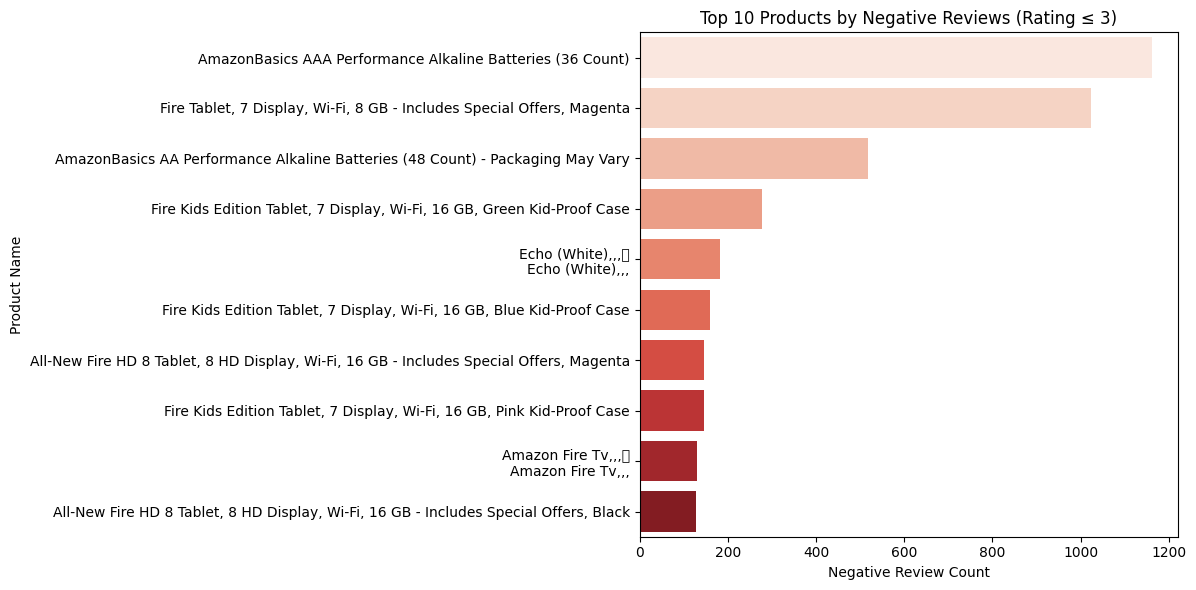

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=negative_counts.head(10), x="negative_review_count", y="product_name", palette="Reds")
plt.title("Top 10 Products by Negative Reviews (Rating ≤ 3)")
plt.xlabel("Negative Review Count")
plt.ylabel("Product Name")
plt.tight_layout()
plt.show()


## 2.4 

# 3. Data Preperation and Feature Engineering

## 3.1 Making dataframes for different kind of models

In [31]:
df1 = review_df[['asins', 'reviews.rating', 'name', 'brand', 'categories',
       'reviews.text', 'reviews.title', 'reviews.username']]
df2 = review_df[["name", "reviews.rating", "reviews.text", "reviews.numHelpful"]]

## 3.2  Data Preperation and Feature Engineering for 1st DF

### 3.2.1 removing null values in this df

In [32]:
review_df_cleaned=df1[~df1['reviews.text'].isnull()].copy()

### 3.2.2 Removing reviews that are too long

In [ ]:
#Removed reviews with more than > 400 words  due to token limitation of Sentence Transformers and computing
review_df_cleaned['token_count'] = review_df_cleaned['reviews.text'].apply(lambda x: len(x.split()))
review_df_cleaned=review_df_cleaned[review_df_cleaned['token_count']<=400]

### 3.2.3 Creating review_sentiment column, review ratings that are above 3 are True and rest are False

In [33]:
review_df_cleaned['review_sentiment']=review_df_cleaned['reviews.rating']>3

### 3.2.4 Removing the duplicates we found through EDA

In [ ]:
review_df_cleaned = review_df_cleaned.drop_duplicates(
    subset=["reviews.title", "reviews.text", "reviews.username", "name"],
    keep="first")

In [49]:
docs = review_df_cleaned['reviews.text'].values

## 3.3 Data Preperation and Feature Engineering for 2nd DF

### 3.3.1 Classify sentiment and handle duplicates

In [ ]:
# Reclassify using ≤ 3 = negative and ≥ 4 = positive
df2["sentiment"] = df2["reviews.rating"].apply(
    lambda r: "negative" if r <= 3 else "positive"
)

# Drop duplicates based on title, text, username, and product name
df2 = df2.drop_duplicates(
    subset=["reviews.title", "reviews.text", "reviews.username", "name"],
    keep="first")
df2.to_csv("labeled_reviews.csv", index=False)

# counts before balancing
counts_before = df2["sentiment"].value_counts()


/tmp/ipython-input-34-2570520918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["sentiment"] = df2["reviews.rating"].apply(


### 3.3.2 Extract the top helpful reviews

In [35]:
import pandas as pd

# Load the labeled dataset
df2 = pd.read_csv("labeled_reviews.csv")

# Replace NaNs in helpful counts with 0
df2["reviews.numHelpful"] = df2["reviews.numHelpful"].fillna(0)

# Define how many top reviews to pick per class per product
TOP_N = 5

# Sort and group to pick
top_reviews = (
    df2
    .sort_values(by="reviews.numHelpful", ascending=False)
    .groupby(["name", "sentiment"])
    .head(TOP_N)
    .reset_index(drop=True)
)

# Quick check
print("Sample top helpful reviews:")
print(top_reviews[["name", "sentiment", "reviews.numHelpful"]].head(10))
print("\nCounts per sentiment per product (first few):")
print(top_reviews.groupby(["sentiment", "name"]).size().unstack(fill_value=0).iloc[:, :5])

# Save for LLM processing
top_reviews.to_csv("top_helpful_reviews.csv", index=False)
print(f"\n✅ Top {TOP_N} helpful reviews per sentiment per product saved to 'top_helpful_reviews.csv'")

Sample top helpful reviews:
                                                name sentiment  \
0  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
1  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
2  Amazon Kindle Lighted Leather Cover,,,\r\nAmaz...  negative   
3  Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...  positive   
4  Oem Amazon Kindle Power Usb Adapter Wall Trave...  negative   
5  AmazonBasics Bluetooth Keyboard for Android De...  positive   
6  Amazon Tap Smart Assistant Alexaenabled (black...  positive   
7  Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...  positive   
8  AmazonBasics Bluetooth Keyboard for Android De...  positive   
9                 Echo (White),,,\r\nEcho (White),,,  negative   

   reviews.numHelpful  
0               780.0  
1               740.0  
2               730.0  
3               650.0  
4               621.0  
5               525.0  
6               434.0  
7               355.0  
8               345.0  
9    

# 4. Feature Selection

1. asins: These are the product ids for products on Amazon it will be useful to differentiate products from one another

2. reviews.rating: These are the ratings of the reviewer, this is useful for us to help train/test our sentiment classification model when run it against the reviews text.

3. name: This is to get the name of the product

4. brand: For topic modeling if we want to include what brand it is, would be useful.

5. categories: Again for topic modeling, when we can try to build a chatbot it would be useful to know the category of the product

6. reviews.text: This is the reviews for the product that our models will all consume for training/testing

7. reviews.title: This was needed mainly to find duplicate reviews for each product

8. reviews.username: This is needed to know if potentially the user has multiple reviews on this product, maybe they can be contradictory, mostly for future use cases.

9. reviews.numHelpful: This is required to see how many people have found the review helpful, so when creating summaries for products we can be more accurate and be able to provide a better sentiment classification.

# 5. Modeling

## 5.1 Generate Text Embeddings (df1)


In [37]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(review_df_cleaned['reviews.text'].values)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


X = embeddings
y = review_df_cleaned['review_sentiment']


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 5.2 Logistic Regression Model to classify sentiment (df1)

In [43]:

# Create and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and print classification metrics
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
logistic_classification_report = classification_report(y_test, y_pred)

              precision    recall  f1-score   support

       False       0.78      0.31      0.44      1654
        True       0.94      0.99      0.97     18744

    accuracy                           0.94     20398
   macro avg       0.86      0.65      0.70     20398
weighted avg       0.93      0.94      0.92     20398



## 5.3 XGboost Classifier (df1)

In [44]:
import xgboost as xgb
# Create and train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

# Predict and print metrics
y_pred = model.predict(X_test)
xgboost_classification_report = classification_report(y_test, y_pred)
print(xgboost_classification_report)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:23:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False       0.90      0.55      0.68      1654
        True       0.96      0.99      0.98     18744

    accuracy                           0.96     20398
   macro avg       0.93      0.77      0.83     20398
weighted avg       0.96      0.96      0.95     20398



## 5.4 Oversampling using SMOTE to make training set balanced (df1)

In [46]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Create and train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_resampled, y_resampled)
print()

# Predict and print metrics
y_pred = model.predict(X_test)
xgboost_classification_report_sampling =  classification_report(y_test, y_pred)
print(xgboost_classification_report_sampling)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:25:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



              precision    recall  f1-score   support

       False       0.67      0.68      0.67      1654
        True       0.97      0.97      0.97     18744

    accuracy                           0.95     20398
   macro avg       0.82      0.82      0.82     20398
weighted avg       0.95      0.95      0.95     20398



## 5.5 Compute scale_pos_weight (df1)

In [47]:
import xgboost as xgb

# Compute scale_pos_weight = (# negative samples) / (# positive samples)
ratio=review_df_cleaned['review_sentiment'].value_counts()[1]/review_df_cleaned['review_sentiment'].value_counts()[0]
model = xgb.XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and print metrics
y_pred = model.predict(X_test)
xgboost_classification_report_scaled = classification_report(y_test, y_pred)
print(xgboost_classification_report_scaled)

/tmp/ipython-input-47-1916858910.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ratio=review_df_cleaned['review_sentiment'].value_counts()[1]/review_df_cleaned['review_sentiment'].value_counts()[0]
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:28:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

       False       0.71      0.69      0.70      1654
        True       0.97      0.97      0.97     18744

    accuracy                           0.95     20398
   macro avg       0.84      0.83      0.84     20398
weighted avg       0.95      0.95      0.95     20398



## 5.6 DistilBert Transformer Pipeline to do Classification (df1)

In [51]:
from transformers import pipeline
from transformers import AutoTokenizer

# Load pipeline and tokenizer
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

texts = docs.tolist()

labels = []
scores = []

def chunk_text(text, max_tokens=512):
    words = text.split()
    chunks = []
    chunk = []
    for word in words:
        chunk.append(word)
        if len(tokenizer(" ".join(chunk))["input_ids"]) >= max_tokens:
            chunks.append(" ".join(chunk))
            chunk = []
    if chunk:
        chunks.append(" ".join(chunk))
    return chunks

for text in texts:
    chunks = chunk_text(text)
    chunk_results = sentiment_pipeline(chunks, truncation=True)

    # Average sentiment score; use a threshold to decide final label
    avg_score = sum(r["score"] if r["label"] == "POSITIVE" else -r["score"] for r in chunk_results) / len(chunk_results)
    label = "POSITIVE" if avg_score >= 0 else "NEGATIVE"

    labels.append(label)
    scores.append(abs(avg_score))



Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


In [52]:
review_df_cleaned['Predicted']=[label=='POSITIVE' for label in labels]

In [53]:
from sklearn.metrics import classification_report
report_review_sentiment = classification_report(review_df_cleaned['review_sentiment'], review_df_cleaned['Predicted'])
print(report_review_sentiment)

              precision    recall  f1-score   support

       False       0.32      0.77      0.45      5445
        True       0.98      0.86      0.91     62546

    accuracy                           0.85     67991
   macro avg       0.65      0.81      0.68     67991
weighted avg       0.92      0.85      0.88     67991



## 5.7 Finetuned DistilBert Sentiment Classification Model (df2)

### 5.7.1 Tokenize the labeled sentiment

Prepares a labeled sentiment dataset (positive vs. negative).

Splits and tokenizes it using DistilBERT.

Saves the processed inputs and labels to disk as JSON.

Saves the tokenizer for downstream use (training/inference)

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
import json

# Load labeled data
df = pd.read_csv("labeled_reviews.csv").dropna(subset=["reviews.text"])
label_map = {"negative": 0, "positive": 1}
df["label"] = df["sentiment"].map(label_map)

# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Tokenization
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_enc = tokenizer(train_df["reviews.text"].tolist(), truncation=True, padding=True, max_length=256)
test_enc = tokenizer(test_df["reviews.text"].tolist(), truncation=True, padding=True, max_length=256)

# Convert BatchEncoding to plain dicts
train_enc_dict = {k: v for k, v in train_enc.items()}
test_enc_dict = {k: v for k, v in test_enc.items()}

# Save as JSON
with open("train_enc.json", "w") as f:
    json.dump({"encodings": train_enc_dict, "labels": train_df["label"].tolist()}, f)

with open("test_enc.json", "w") as f:
    json.dump({"encodings": test_enc_dict, "labels": test_df["label"].tolist()}, f)

# Save tokenizer and confirm
tokenizer.save_pretrained("tokenizer")
print(" Tokenized encodings and labels saved as JSON. Let's load and verify next.")

 Tokenized encodings and labels saved as JSON. Let's load and verify next.


### 5.7.2 Convert to PyTorch-Ready datasets

This block converts the saved tokenized JSON data into PyTorch-ready datasets, which can be fed into Hugging Face's Trainer or native DataLoader loops.

In [56]:
import json
import torch
from torch.utils.data import Dataset

# Load JSON data
with open("train_enc.json") as f:
    train_data = json.load(f)
with open("test_enc.json") as f:
    test_data = json.load(f)

# Define Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Instantiate datasets
train_ds = SentimentDataset(train_data["encodings"], train_data["labels"])
test_ds = SentimentDataset(test_data["encodings"], test_data["labels"])
print(f" Loaded datasets: {len(train_ds)} train, {len(test_ds)} test samples.")


 Loaded datasets: 54392 train, 13599 test samples.


### 5.7.3 Create fine-tuned and balanced model using CrossEntropyLoss

Added class weights to fix the severe imbalance between positive and negative reviews.

Creating a fine-tuned and balanced model saved to disk and ready for inference.

In [57]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

import pandas as pd
df = pd.read_csv("labeled_reviews.csv")
counts = df["sentiment"].value_counts()
total = len(df)

# Computing the class weights
class_weights = torch.tensor(
    [total/counts["negative"], total/counts["positive"]],
    dtype=torch.float)

# We create a custom trainer with the weighted loss
class WeightedTrainer(Trainer):
    #overriding here
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(logits.device)) #Uses CrossEntropyLoss(weight=class_weights) to penalize the model more for misclassifying the minority class.
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

"""
Typical Hugging Face training config.

Trains for 3 epochs, saves checkpoints every 500 steps, logs every 100 steps.

do_train=True, do_eval=True ensure both training and evaluation occur
"""
training_args = TrainingArguments(
    output_dir="sentiment_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=2,
    do_train=True,
    do_eval=True,
    eval_steps=500,
    save_steps=500
)
# Initializes a binary classification model (positive vs negative).
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

#Train
trainer.train()
trainer.save_model("sentiment_model")
print("✅ Model trained and saved successfully.")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: monishy1 (monishy1-university-of-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.572000
200,0.538800
300,0.589500
400,0.501700
500,0.517400
600,0.462000
700,0.487000
800,0.407900
900,0.468400
1000,0.429100


✅ Model trained and saved successfully.


### 5.7.4 Run Prediction on Test Set

In [58]:
from sklearn.metrics import classification_report
import json

results = trainer.predict(test_ds)
y_pred = results.predictions.argmax(axis=1)
true_labels = [item["labels"].item() for item in test_ds]

classification_report_distilbert_finetuned = classification_report(
    true_labels,
    y_pred,
    target_names=["negative","positive"],
    output_dict=True
)

with open("classification_report_distilbert_finetuned.json", "w") as f:
    json.dump(classification_report_distilbert_finetuned, f, indent=4)

print("Evaluation results:\n", json.dumps(classification_report_distilbert_finetuned, indent=2))


Evaluation results:
 {
  "negative": {
    "precision": 0.8348439073514602,
    "recall": 0.7661737523105361,
    "f1-score": 0.7990361445783133,
    "support": 1082.0
  },
  "positive": {
    "precision": 0.9799301919720768,
    "recall": 0.986897818966206,
    "f1-score": 0.9834016638140349,
    "support": 12517.0
  },
  "accuracy": 0.9693359805868078,
  "macro avg": {
    "precision": 0.9073870496617684,
    "recall": 0.8765357856383711,
    "f1-score": 0.8912189041961741,
    "support": 13599.0
  },
  "weighted avg": {
    "precision": 0.9683864490527807,
    "recall": 0.9693359805868078,
    "f1-score": 0.9687326814026039,
    "support": 13599.0
  }
}


### 5.7.5 Prepare review texts for inference

setting up all raw review texts in the proper tokenized tensor format that your BERT model can understand for sentiment inference (i.e., predicting the sentiment label for each review)

In [59]:
import pandas as pd

df = pd.read_csv("amazon_reviews.csv")
df = df[df["reviews.text"].apply(lambda x: isinstance(x, str))].copy()


In [60]:
"""
The reviews are processed in chunks of 1000 to avoid memory overflow.

truncation=True: cuts off text beyond 256 tokens.

padding="max_length": pads all sequences to exactly 256 tokens.

return_tensors="pt": outputs PyTorch tensors.

Each enc contains:

input_ids: token IDs (numerical representation)

attention_mask: indicates which tokens are actual text vs. padding (1 for real tokens, 0 for padding)


"""

from transformers import DistilBertTokenizerFast
import torch

tokenizer = DistilBertTokenizerFast.from_pretrained("tokenizer")
texts = df["reviews.text"].tolist()

input_ids_list, attention_masks_list = [], []
batch_size = 1000

# This loop ensures each batch of 1000 reviews is:

# Tokenized into input_ids and attention_mask

# Padded and truncated to 256 tokens

for i in range(0, len(texts), batch_size):
    batch = texts[i : i + batch_size]
    enc = tokenizer(
        batch,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    input_ids_list.append(enc["input_ids"])
    attention_masks_list.append(enc["attention_mask"])

# Then everything is concatenated into tensors:
input_ids = torch.cat(input_ids_list)
attention_masks = torch.cat(attention_masks_list)


### 5.7.6 Predict sentiment of all product reviews using the classifier

To predict the sentiment (positive or negative) of all product reviews using the fine-tuned model and save the results into a new CSV.

Output file: all_reviews_with_preds.csv

Includes every review’s predicted sentiment.

This file will later be used for aggregating sentiment per product, summarizing, or visualizing trends.

In [61]:
import time
import torch
from transformers import DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("sentiment_model").to('cuda').eval()

#Setup Inference Pipeline
dataset = TensorDataset(input_ids, attention_masks)
loader = DataLoader(dataset, batch_size=128)

#Running the inference pipeline
start = time.time()
preds = []
with torch.no_grad():
    for ids, masks in loader:
        ids, masks = ids.cuda(), masks.cuda()
        with autocast():
            outputs = model(input_ids=ids, attention_mask=masks)
        preds.extend(torch.argmax(outputs.logits, dim=1).tolist())
end = time.time()

print(f"✅ Inference complete in {end - start:.2f} seconds.")
df["pred_label"] = preds
df["pred_sentiment"] = df["pred_label"].map({0: "negative", 1: "positive"})
# Attach predictions to df
df.to_csv("all_reviews_with_preds.csv", index=False)


✅ Inference complete in 28.03 seconds.


### 5.7.7 Product-level sentiment aggregation

performs product-level sentiment aggregation and saves a CSV of summary statistics that later pass to an LLM for review generation.

In [62]:
import pandas as pd

df = pd.read_csv("all_reviews_with_preds.csv")
# Aggregate Sentiment Stats by Product
stats = (
    df.groupby("name")["pred_sentiment"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

#Formatting to later use with LLM
stats["review_count"] = df.groupby("name").size()
stats.reset_index(inplace=True)
stats.rename(columns={"negative":"neg_pct", "positive":"pos_pct"}, inplace=True)

stats.to_csv("product_sentiment_stats.csv", index=False)


### 5.7.8 Extract most helpful reviews for each product based on sentiment

For every product:

Find the most helpful positive review

Find the most helpful negative review
And save them side by side for possible use in summaries or prompts to the LLM.

In [63]:
#Finding the top negative and positive based of number of helpful column

top_pos = df[df.pred_sentiment=="positive"].sort_values(["name","reviews.numHelpful"], ascending=False).groupby("name").first().reset_index()
top_neg = df[df.pred_sentiment=="negative"].sort_values(["name","reviews.numHelpful"], ascending=False).groupby("name").first().reset_index()

top_reviews = top_pos.merge(top_neg, on="name", suffixes=("_pos","_neg"))
top_reviews[["name","reviews.text_pos","reviews.text_neg"]].to_csv("top_reviews_per_product.csv", index=False)


This CSV is a perfect supplement to product_sentiment_stats.csv.
can feed both into  LLM to write well-rounded summaries:

Quantitative stats (pos_pct, neg_pct, review_count)

Qualitative highlights (top helpful review examples)

We now have

Quantitative stats: percent of positive/negative reviews per product + review counts

Qualitative review selection: Most helpful positive and negative review per product

These two together give us a strong base for:

Sentiment analysis

Product summaries

AI-generated overviews for shoppers or stakeholders

## 5.8 LLM Model to create summary for each product

### 5.8.1 Third Party LLM setup with Mistralai (HuggingFace)

In [64]:
import pandas as pd

# Load sentiment stats and sample reviews
stats = pd.read_csv("product_sentiment_stats.csv")
top_reviews = pd.read_csv("top_reviews_per_product.csv")

In [ ]:
from huggingface_hub import login

login(token="*")  # Hugging Face token (removed for here)


### 5.8.2 Model & Tokenizer Setup and Inference Pipeline

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = "mistralai/Mistral-7B-Instruct-v0.1"  # gated model with access

# Loads the tokenizer associated with the model (tokenizes input text into IDs).
tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=True)

'''
Loads the causal language model:

torch_dtype=torch.float16: reduces memory usage (important for 7B models).

device_map="auto": automatically distributes the model across available GPU(s) or CPU.

use_auth_token=True: required due to restricted access.
'''

model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto", use_auth_token=True)

'''
max_new_tokens=150: limit the output to 150 new tokens (words/punctuation).

temperature=0.7: controls randomness. Lower is more deterministic; 0.7 is moderately creative.

device_map="auto" again ensures the model uses GPU if available.
'''
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    temperature=0.7,
    device_map="auto"
)


### 5.8.3 Generate summaries per product using sentiment stats and top reviews with LLM


Automatically generate short product summaries using an LLM based on:

Sentiment distribution per product.

Most helpful positive and negative reviews.

In [ ]:
import pandas as pd

stats = pd.read_csv("product_sentiment_stats.csv")
reviews = pd.read_csv("top_reviews_per_product.csv")

PROMPT = """
Product: {name}
Reviews: {review_count}, 👍 {pos_pct:.0%}, 👎 {neg_pct:.0%}
Top Positive: "{text_pos}"
Top Negative: "{text_neg}"

Write a concise 1–2 sentence summary: key strength, main issue, and overall recommendation.
"""

summaries = []
for _, r in stats.iterrows():
    revs = reviews[reviews["name"] == r["name"]]
    if revs.empty:
      continue

    rev = revs.iloc[0]
    prompt = PROMPT.format(
        name=r["name"],
        review_count=r["review_count"],
        pos_pct=r["pos_pct"],
        neg_pct=r["neg_pct"],
        text_pos=rev["reviews.text_pos"],
        text_neg=rev["reviews.text_neg"],
    )
    out = generator(prompt)[0]["generated_text"].strip()
    summaries.append({"name": r["name"], "summary": out})

pd.DataFrame(summaries).to_csv("product_summaries.csv", index=False)



# 6. Evaluation

## 6.1 Logistic Regression Model

              precision    recall  f1-score   support

       False       0.78      0.31      0.44      1654
        True       0.94      0.99      0.97     18744

    accuracy                           0.94     20398
   macro avg       0.86      0.65      0.70     20398
weighted avg       0.93      0.94      0.92     20398

The True class represents positive reviews and False class represents negative reviews

High accuracy (94%): But this is misleading due to the heavy imbalance.

Low recall for the False class (31%): The model fails to correctly identify most of the minority class examples.

High recall for the True class (99%): It detects the majority class very well.

Macro F1-score (0.70) is much lower than weighted F1-score (0.92), signaling poor minority class performance.

This model prioritizes the majority class and may not be suitable if identifying the minority class (negative) is critical.

## 6.2 XGboost Classifier

              precision    recall  f1-score   support

       False       0.90      0.55      0.68      1654
        True       0.96      0.99      0.98     18744

    accuracy                           0.96     20398
   macro avg       0.93      0.77      0.83     20398
weighted avg       0.96      0.96      0.95     20398

Significant improvement in minority class (False) precision (0.90) and f1-score (0.68) compared to Logistic Regression.

Recall for False is still 0.55: The model misses ~45% of False cases.

Excellent performance on the majority class (True) with near-perfect recall and F1.

Macro-average F1 improved to 0.83, showing better balance across both classes.

Weighted-average F1 is high (0.95), dominated by the majority class but still indicates strong model performance overall.

## 6.3 SMOTE with XGboost

              precision    recall  f1-score   support

       False       0.67      0.68      0.67      1654
        True       0.97      0.97      0.97     18744

    accuracy                           0.95     20398
   macro avg       0.82      0.82      0.82     20398
weighted avg       0.95      0.95      0.95     20398

Much better balance: SMOTE helped the model learn the minority class (False) more effectively — recall rose from 0.55 → 0.68.

F1-score for False improved significantly to 0.67, making this model much more reliable in detecting rare cases.

Macro average F1 is now 0.82, indicating a healthy balance across both classes.

The model retains high performance on the majority class (True), with very little trade-off.

We still believe that we can do better in terms of recall and precision of Negative Review Classification

## 6.4 XGboost with pos-scale weight

              precision    recall  f1-score   support

       False       0.71      0.69      0.70      1654
        True       0.97      0.97      0.97     18744

    accuracy                           0.95     20398
   macro avg       0.84      0.83      0.84     20398
weighted avg       0.95      0.95      0.95     20398

Best minority performance yet: F1 for class False is now 0.70 (↑ from SMOTE’s 0.67 and baseline’s 0.68).

Macro average F1 of 0.84 is the highest across all tested models, showing excellent balance.

Precision and recall for the minority class are nearly symmetrical (0.71 vs. 0.69), indicating stable learning.

High accuracy (95%) is maintained without sacrificing minority class detection.

We think we can still do better

## 6.5 DistilBERT Tranformer Pipeline Sentiment Classification

              precision    recall  f1-score   support

       False       0.32      0.77      0.45      5445
        True       0.98      0.86      0.91     62546

    accuracy                           0.85     67991
   macro avg       0.65      0.81      0.68     67991
weighted avg       0.92      0.85      0.88     67991


Low precision for negative reviews (0.32):

The model flags many false positives in the negative class — it struggles to confidently identify real negatives.

High recall for negatives (0.77):

When it does find a negative review, it catches a large portion of them.

Positive class performance is strong:

Very high precision (0.98) and decent recall (0.86).

We have achieved a better recall but we see the precision for negative reviews significantly dropped

## 6.6 FineTuned DistilBERT Sentiment Classification Model

Evaluation results:

 {

  "negative": {

    "precision": 0.8348439073514602,

    "recall": 0.7661737523105361,
    
    "f1-score": 0.7990361445783133,
    
    "support": 1082.0
  },

  "positive": {
  
    "precision": 0.9799301919720768,
  
    "recall": 0.986897818966206,
  
    "f1-score": 0.9834016638140349,
  
    "support": 12517.0
  
  },
  
  "accuracy": 0.9693359805868078,
  
  "macro avg": {
  
    "precision": 0.9073870496617684,
  
    "recall": 0.8765357856383711,
  
    "f1-score": 0.8912189041961741,
  
    "support": 13599.0
  
  },
  
  "weighted avg": {
  
    "precision": 0.9683864490527807,
  
    "recall": 0.9693359805868078,
  
    "f1-score": 0.9687326814026039,
  
    "support": 13599.0
  
  }

}


Balanced performance:

Unlike earlier models, this version doesn’t neglect the minority class.

Negative class recall: 76.6%, precision: 83.5% – this is strong for an imbalanced dataset.

Excellent Positive Class Performance:

Almost perfect: 98% precision, 99% recall.

This makes the model very reliable in identifying positive reviews.

Use of Weighted CrossEntropyLoss:

Using class weights helped mitigate the class imbalance problem.

Leads to higher macro average F1 (0.89) vs. 0.68 in previous pipeline version.

## 6.7 LLM to generate Summary per product

We were able to get detailed and useful summary description of each product highlighting positive and negative sentiment for each.

Example The below is a report of a product summary that is saved in the csv of product_summaries.csv,

"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue","Product: All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue

Reviews: 82, 👍 94%, 👎 6%

Top Positive: ""I was shopping for a tablet for my mother. She uses her phone for games and social media, but she wanted a larger device, but wasnt interested in using features that may come with a much pricier tablet. This tablet is PERFECT for her. Battery lasts long, she can watch her shows, play games, and do social media while at her doctor appointments. It's light, durable, and a great price since she's on a fixed income. This tablet is so good, I'm still surprised at how good a price Best Buy had. Definitely recommend. I might even grab one myself!""


Top Negative: ""This is not the first kindle i buy, but the others were for my kids or gifted to kids so they broke at some point. This one was for me, i didn‚Äôt hurry to buy a cover as i am a veeery careful person. Well i was sorry to see the back (yes, the back) cracked within a month, no drop whatsoever, i keep it on my bedside table to read at night.""

Write a concise 1–2 sentence summary: key strength, main issue, and overall recommendation.

The key strength of this tablet is its affordability and versatility, making it perfect for those on a fixed income or who want a larger device without breaking the bank. The main issue is the durability, with some users reporting cracks within a month of purchase. Overall, it is recommended for those who prioritize affordability and versatility over durability."

--
As we see this is a very good report that a business owner or customer can use to understand the sentiment of a product

## 6.x Conclusion

We see that the Fine Tuned DistilBERT model with high level embeddings and that which uses weighted CrossEntropy loss has performed the best to accurately classify both negative and positive sentiment.

The LLM generated report of each product contains highly useful information along with a summary of each product based on the sentiment of reviews of the product.

**NEED TO FILL FOR OTHER MODEL**

# 7. Deployment

# 8 Discussion and Conclusions